In [1]:
# FINAL
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from urllib.parse import quote_plus

In [2]:
# --- MAIN EXECUTION ---
query = """
SELECT ac_month_date, agent_name, lob, reporting_line, nep, nic, noc, nop_t 
FROM ads.fct_all_lob_ag_acy_mly 
WHERE ac_month_date >= '2020-01-01'
"""
# --- DB CONNECTION ---
try:
    connection = psycopg2.connect(
        host = "172.16.10.212",
        dbname = "PIB_PRD",
        user = "usr_app_pdi",
        password = 'Usr@ppPd!#123',
        port = "5432"
    )
    print("Connected to the database")

    cursor = connection.cursor()
    dff = pd.read_sql_query(query, connection)
    print("DataFrame Fetched Successfully!")
    print(dff.head())

except Exception as e:
    print("Error: Unable to connect to the database")
    print(e)

Connected to the database


C:\Users\ananya.datta\AppData\Local\Temp\ipykernel_6116\982913816.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dff = pd.read_sql_query(query, connection)


DataFrame Fetched Successfully!
  ac_month_date             agent_name  lob reporting_line  nep  nic  noc  \
0    2024-11-01  Suria Padu Enterprise  MOT       Branches  0.0  0.0  0.0   
1    2024-11-01             KRY AGENCY  MOT       Branches  0.0  0.0  0.0   
2    2024-11-01             KRY AGENCY  MOT       Branches  0.0  0.0  0.0   
3    2024-11-01             KRY AGENCY  MOT       Branches  0.0  0.0  0.0   
4    2024-11-01             KRY AGENCY  MOT       Branches  0.0  0.0  0.0   

   nop_t  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  


In [3]:
dff.to_csv('AGENTVIEW_DATA.csv',index=False)
# dff = pd.read_csv(r'C:\Users\ananya.datta\OneDrive - Fairfax Asia Ltd\Desktop\Project 2 - Agent Scorecard\AGENTVIEW_DATA.csv')
dff.shape
dff.ac_month_date.value_counts()

ac_month_date
2023-04-01    93493
2023-01-01    93220
2023-07-01    89716
2023-10-01    84580
2024-01-01    82824
2023-05-01    82613
2025-01-01    80333
2025-04-01    80318
2023-02-01    80271
2023-08-01    79918
2024-07-01    78514
2023-03-01    78495
2024-04-01    78443
2024-10-01    77825
2023-06-01    77818
2024-03-01    76428
2023-12-01    76138
2024-12-01    74938
2024-06-01    74442
2023-11-01    73566
2025-05-01    72868
2023-09-01    72567
2024-05-01    70434
2024-02-01    69735
2024-08-01    69644
2024-09-01    68651
2025-02-01    68600
2024-11-01    66931
2025-03-01    64384
2022-12-01    47588
2022-06-01    45593
2022-09-01    44573
2022-07-01    44424
2022-08-01    44113
2022-10-01    44046
2022-05-01    43890
2022-11-01    43750
2022-03-01    43582
2022-02-01    43099
2022-04-01    42877
2022-01-01    41431
2025-06-01     9818
Name: count, dtype: int64

In [7]:
# ------------------INITIAL CLEANUP------------------------
df = dff.copy()
df['ac_month_date'] = pd.to_datetime(df['ac_month_date'])
df = df[df['ac_month_date'] >= '2021-01-01']
df = df[~((df['nep'] == 0))]
df = df[~((df['nop_t'] == 0))]
df = df[df['nic'] >= 0]
df['lob'] = df['lob'].replace({'AVI': 'HUL', 'UNK': 'HUL', 'ZNA': 'HUL'})
df = df.dropna(subset=['agent_name', 'nep'])

In [8]:
df.shape

(382284, 8)

In [9]:
df['account_yr'] = df['ac_month_date'].dt.year
df['month'] = df['ac_month_date'].dt.month

In [10]:
#-----------------------SET CONSTANTS------------------------------
lob_thresholds = {
    'PAC': 0.50, 'FIR': 0.50, 'LIA': 0.50, 'ENG': 0.60, 'WRK': 0.20,
    'ACC': 0.45, 'MAR': 0.35, 'MED': 0.65, 'BON': 0.10, 'HUL': 0.65, 'MOT': 0.75
}
WEIGHT_PROFITABILITY = 0.40
WEIGHT_CLAIMS = 0.30
WEIGHT_GWP_GROWTH = 0.30

In [11]:
df.shape

(382284, 10)

In [12]:
# ------------------------HELPER FUNCTIONS--------------------------
def divide(x, y):
    return x / y if y != 0 else float('nan')

def normalize_columns(col):
    min_val, max_val = col.min(), col.max()
    return (col - min_val) / (max_val - min_val) if min_val != max_val else pd.Series([np.nan]*len(col), index=col.index)

def classify_agents(df, score_col='final_score', ratio_col='nic/nep ratio', score_pct=0.75, ratio_pct=0.70):
    df[ratio_col] = df[ratio_col].clip(lower=0)
    score_thresh = df[score_col].quantile(score_pct)
    ratio_thresh = df[ratio_col].quantile(ratio_pct)
    df['score_level'] = np.where(df[score_col] > score_thresh, 'High', 'Low')
    df['ratio_level'] = np.where(df[ratio_col] > ratio_thresh, 'High', 'Low')
    def assign_class(row):
        if row['score_level'] == 'High' and row['ratio_level'] == 'Low':
            return 'Efficient Performer'
        elif row['score_level'] == 'High' and row['ratio_level'] == 'High':
            return 'Costly Performer'
        elif row['score_level'] == 'Low' and row['ratio_level'] == 'High':
            return 'High-Risk Underperformer'
        else:
            return 'Low-Impact Agent'
    df['agent_class'] = df.apply(assign_class, axis=1)
    return df


In [13]:
def process_cumulative_classification(df):
    df['ac_month_date'] = pd.to_datetime(df['ac_month_date'])
    df['year'] = df['ac_month_date'].dt.year
    df['month'] = df['ac_month_date'].dt.month

    # Sort and compute cumulative sums
    df = df.sort_values(['agent_name', 'lob', 'reporting_line', 'ac_month_date'])
    df['cum_nep'] = df.groupby(['agent_name', 'lob', 'reporting_line'])['nep'].cumsum()
    df['cum_nic'] = df.groupby(['agent_name', 'lob', 'reporting_line'])['nic'].cumsum()
    df['cum_noc'] = df.groupby(['agent_name', 'lob', 'reporting_line'])['noc'].cumsum()
    df['cum_nop_t'] = df.groupby(['agent_name', 'lob', 'reporting_line'])['nop_t'].cumsum()

    # Monthly snapshot
    grouped = df.groupby(['agent_name', 'lob', 'reporting_line', 'ac_month_date'], as_index=False).last()
    grouped['frequency'] = grouped['cum_noc'] / grouped['cum_nop_t'].replace(0, np.nan)
    grouped['severity'] = grouped['cum_nic'] / grouped['cum_noc'].replace(0, np.nan)
    grouped['loss_ratio'] = grouped['cum_nic'] / grouped['cum_nep'].replace(0, np.nan)

    grouped['lob_score'] = grouped['lob'].map(lambda lob: lob_thresholds.get(lob, 0.75)) - grouped['loss_ratio']
    grouped['Nlob_score'] = normalize_columns(grouped['lob_score'])
    grouped['claims_score'] = grouped['frequency'] + grouped['severity']
    grouped['Nclaims_score'] = normalize_columns(grouped['claims_score'])

    # Construct reference date for NEP growth logic
    def get_ref_date(row):
        if row['month'] == 1:
            return None  # No growth in January
        elif row['month'] == 12:
            return row['ac_month_date'] - pd.DateOffset(years=1)
        else:
            return row['ac_month_date'] - pd.DateOffset(months=1)

    grouped['ref_date'] = grouped.apply(get_ref_date, axis=1)

    # Create previous NEP map
    prev_nep = grouped[['agent_name', 'lob', 'reporting_line', 'ac_month_date', 'cum_nep']]
    prev_nep.columns = ['agent_name', 'lob', 'reporting_line', 'ref_date', 'ref_cum_nep']

    # Merge current with reference NEP
    grouped = pd.merge(grouped, prev_nep, on=['agent_name', 'lob', 'reporting_line', 'ref_date'], how='left')
    grouped['nep_growth'] = (grouped['cum_nep'] - grouped['ref_cum_nep']) / grouped['ref_cum_nep'].replace(0, np.nan)
    grouped['Nnep_growth'] = normalize_columns(grouped['nep_growth'].fillna(0))

    # Final composite score
    grouped['final_score'] = (
        WEIGHT_PROFITABILITY * grouped['Nlob_score'] +
        WEIGHT_CLAIMS * grouped['Nclaims_score'] +
        WEIGHT_GWP_GROWTH * grouped['Nnep_growth']
    )

    # Aggregate across LOBs
    summary = grouped.groupby(['agent_name', 'reporting_line', 'ac_month_date'], as_index=False).agg({
        'cum_nep': 'sum',
        'cum_nic': 'sum',
        'cum_noc': 'sum',
        'cum_nop_t': 'sum',
        'final_score': 'sum'
    })
    summary['nic/nep ratio'] = summary['cum_nic'] / summary['cum_nep'].replace(0, np.nan)
    summary['year'] = summary['ac_month_date'].dt.year

    # Year-wise classification (using all months in year for each reporting_line)
    classified_results = []

    for (reporting_line, year), group in summary.groupby(['reporting_line', 'year']):
        score_thresh = group['final_score'].quantile(0.75)
        ratio_thresh = group['nic/nep ratio'].quantile(0.70)

        group['score_level'] = np.where(group['final_score'] > score_thresh, 'High', 'Low')
        group['ratio_level'] = np.where(group['nic/nep ratio'] > ratio_thresh, 'High', 'Low')

        def classify(row):
            if row['score_level'] == 'High' and row['ratio_level'] == 'Low':
                return 'Efficient Performer'
            elif row['score_level'] == 'High' and row['ratio_level'] == 'High':
                return 'Costly Performer'
            elif row['score_level'] == 'Low' and row['ratio_level'] == 'High':
                return 'High-Risk Underperformer'
            else:
                return 'Low-Impact Agent'

        group['agent_class'] = group.apply(classify, axis=1)
        classified_results.append(group)

    final_df = pd.concat(classified_results, ignore_index=True)
    return final_df


In [15]:
import time

start = time.time()
final_df = process_cumulative_classification(df)
print(f"Took {time.time() - start:.2f} seconds")

Took 22.36 seconds


In [20]:
# --- DATABASE CONNECTION AND UPLOAD ---
# Define the database connection parameters
host = "172.16.10.212"
dbname = "PIB_PRD"
user = "usr_app_pdi"
password = 'Usr@ppPd!#123'
port = "5432"  # Default is 5432

# Safely encode credentials
safe_user = quote_plus(user)
safe_password = quote_plus(password)

# Build connection string
connection_string = f'postgresql+psycopg2://{safe_user}:{safe_password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
final_df.to_sql('all_lob_ag_class_final', engine, schema='ads', if_exists='replace', index=False)
print("Dataframe uploaded successfully.")

Dataframe uploaded successfully.


In [21]:
if cursor:
    cursor.close()
if connection:
    connection.close()

## CHECKS

In [16]:
final_df.head()

,agent_name,reporting_line,ac_month_date,cum_nep,cum_nic,cum_noc,cum_nop_t,final_score,nic/nep ratio,year,score_level,ratio_level,agent_class
0,AG Agencies Sdn Bhd,Alternative Channel,2022-12-01,118.238681,0.00,0.0,11.000000,0.000000,0.000000,2022,Low,Low,Low-Impact Agent
1,AHSA Risk Management Sdn Bhd,Alternative Channel,2022-09-01,669.660852,0.00,0.0,11.000000,0.000000,0.000000,2022,Low,Low,Low-Impact Agent
2,AHSA Risk Management Sdn Bhd,Alternative Channel,2022-10-01,5900.072857,0.00,0.0,16.000000,0.000000,0.000000,2022,Low,Low,Low-Impact Agent
3,AHSA Risk Management Sdn Bhd,Alternative Channel,2022-11-01,688.477822,6386.25,1.0,22.000000,0.397688,9.275898,2022,High,High,Costly Performer
4,AHSA Risk Management Sdn Bhd,Alternative Channel,2022-12-01,6590.280627,0.00,0.0,29.333333,0.000000,0.000000,2022,Low,Low,Low-Impact Agent


In [19]:
pivot_df

,agent_class,Efficient Performer,Low-Impact Agent
month_num,month,,
1,Jan,0.0,1.0
2,Feb,0.0,1.0
3,Mar,0.0,1.0
4,Apr,0.0,1.0
5,May,1.0,0.0
6,Jun,1.0,0.0
7,Jul,1.0,0.0
8,Aug,1.0,0.0
9,Sep,1.0,0.0


axs type before reshape: <class 'numpy.ndarray'>
axs type after reshape: <class 'numpy.ndarray'>, length: 4


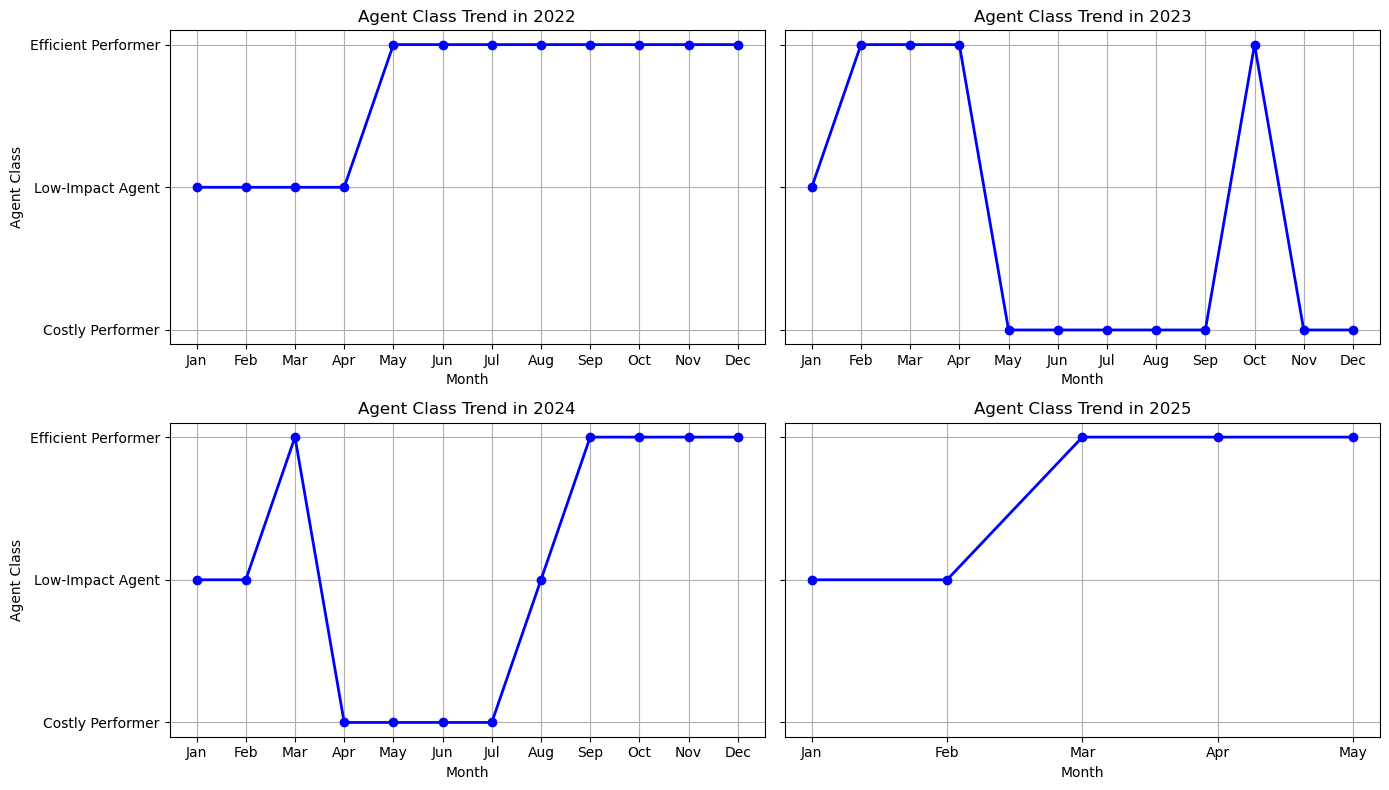

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter data for A K SEER AGENCY only
agent_data = final_df[final_df['agent_name'] == 'A K SEER AGENCY'].copy()

agent_data['year'] = agent_data['ac_month_date'].dt.year
agent_data['month_num'] = agent_data['ac_month_date'].dt.month
agent_data['month_name'] = agent_data['ac_month_date'].dt.strftime('%b')

category_order = [
    'High-Risk Underperformer',
    'Costly Performer',
    'Low-Impact Agent',
    'Efficient Performer'
]

category_to_num = {label: i for i, label in enumerate(category_order)}
num_to_category = {i: label for label, i in category_to_num.items()}

agent_data['agent_class'] = agent_data['agent_class'].str.strip().str.title()
agent_data['class_num'] = agent_data['agent_class'].map(category_to_num)

years = sorted(agent_data['year'].dropna().unique())

n_cols = 2
n_rows = (len(years) + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharey=True)

# Debug prints
print(f"axs type before reshape: {type(axs)}")
if isinstance(axs, plt.Axes):
    axs = np.array([axs])
elif axs.ndim == 2:
    axs = axs.flatten()

print(f"axs type after reshape: {type(axs)}, length: {len(axs)}")

for i, year in enumerate(years):
    ax = axs[i]

    data_year = agent_data[agent_data['year'] == year]

    mode_per_month = data_year.groupby('month_num')['class_num'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    months = mode_per_month.index
    class_nums = mode_per_month.values
    month_labels = [pd.Timestamp(month=mn, day=1, year=year).strftime('%b') for mn in months]

    ax.plot(months, class_nums, marker='o', linewidth=2, color='blue')

    ax.set_title(f'Agent Class Trend in {year}')
    ax.set_xticks(months)
    ax.set_xticklabels(month_labels)
    ax.set_xlabel('Month')
    ax.grid(True)

    if i % n_cols == 0:
        ax.set_ylabel('Agent Class')
        ax.set_yticks(list(num_to_category.keys()))
        ax.set_yticklabels(list(num_to_category.values()))

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


axs type before reshape: <class 'numpy.ndarray'>
axs type after reshape: <class 'numpy.ndarray'>, length: 4


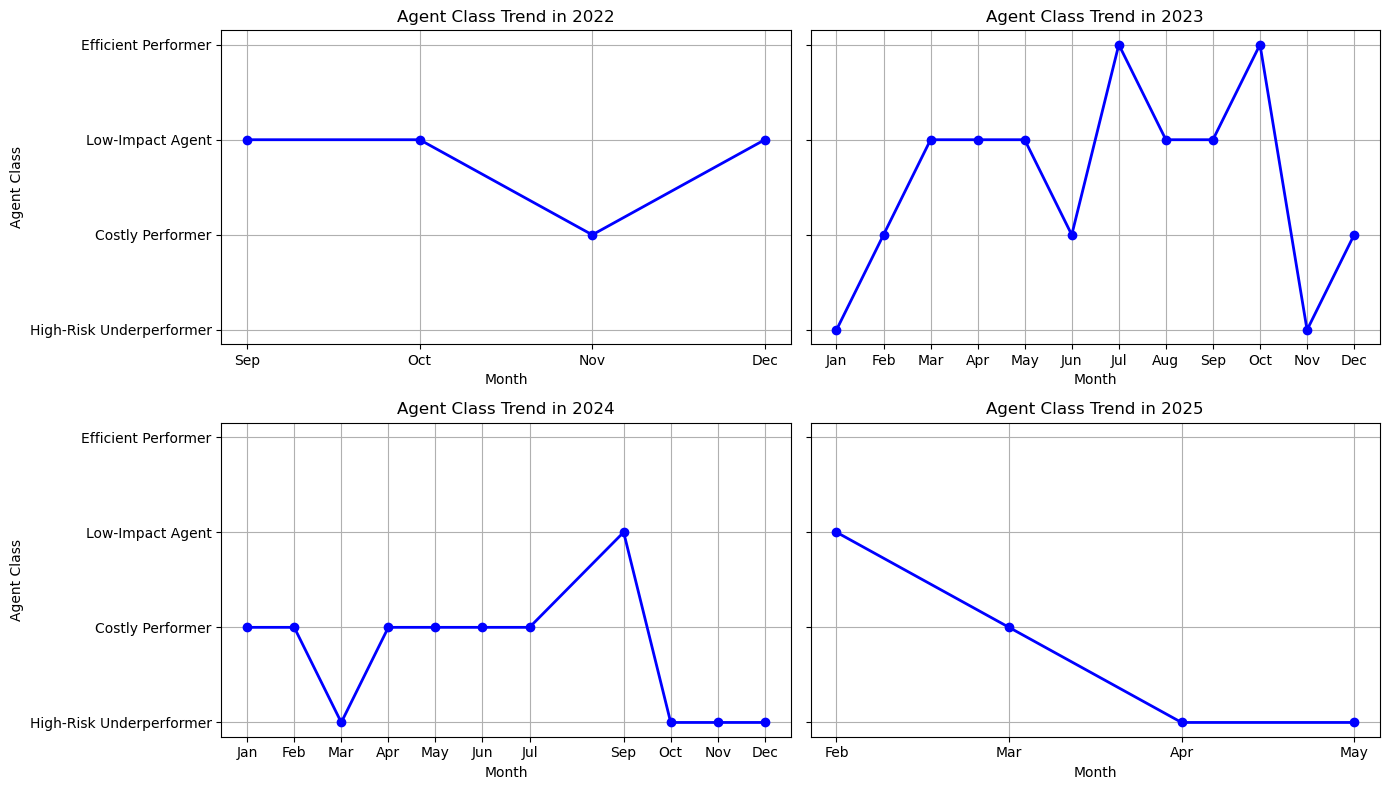

In [18]:
# Filter data for A K SEER AGENCY only
agent_data = final_df[final_df['agent_name'] == 'AHSA Risk Management Sdn Bhd'].copy()

agent_data['year'] = agent_data['ac_month_date'].dt.year
agent_data['month_num'] = agent_data['ac_month_date'].dt.month
agent_data['month_name'] = agent_data['ac_month_date'].dt.strftime('%b')

category_order = [
    'High-Risk Underperformer',
    'Costly Performer',
    'Low-Impact Agent',
    'Efficient Performer'
]

category_to_num = {label: i for i, label in enumerate(category_order)}
num_to_category = {i: label for label, i in category_to_num.items()}

agent_data['agent_class'] = agent_data['agent_class'].str.strip().str.title()
agent_data['class_num'] = agent_data['agent_class'].map(category_to_num)

years = sorted(agent_data['year'].dropna().unique())

n_cols = 2
n_rows = (len(years) + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharey=True)

# Debug prints
print(f"axs type before reshape: {type(axs)}")
if isinstance(axs, plt.Axes):
    axs = np.array([axs])
elif axs.ndim == 2:
    axs = axs.flatten()

print(f"axs type after reshape: {type(axs)}, length: {len(axs)}")

for i, year in enumerate(years):
    ax = axs[i]

    data_year = agent_data[agent_data['year'] == year]

    mode_per_month = data_year.groupby('month_num')['class_num'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    months = mode_per_month.index
    class_nums = mode_per_month.values
    month_labels = [pd.Timestamp(month=mn, day=1, year=year).strftime('%b') for mn in months]

    ax.plot(months, class_nums, marker='o', linewidth=2, color='blue')

    ax.set_title(f'Agent Class Trend in {year}')
    ax.set_xticks(months)
    ax.set_xticklabels(month_labels)
    ax.set_xlabel('Month')
    ax.grid(True)

    if i % n_cols == 0:
        ax.set_ylabel('Agent Class')
        ax.set_yticks(list(num_to_category.keys()))
        ax.set_yticklabels(list(num_to_category.values()))

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
